In [85]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [11]:
# Define dataset paths
base_path = r'C:\ILW\fake product\Data'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

print(f"Base dataset path: {base_path}")
print(f"Train path: {train_path}")
print(f"Test path: {test_path}")

Base dataset path: C:\ILW\fake product\Data
Train path: C:\ILW\fake product\Data\train
Test path: C:\ILW\fake product\Data\test


In [17]:

def preprocess_images(dataset_path, image_size=(48, 48)):
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path not found: {dataset_path}")

    images, labels = [], []
    classes = sorted(os.listdir(dataset_path))  # Class names
    class_map = {label: idx for idx, label in enumerate(classes)}

    for label in classes:
        label_folder_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_folder_path):
            print(f"Skipping non-directory: {label_folder_path}")
            continue

        img_names = os.listdir(label_folder_path)
        
        for img_name in tqdm(img_names, desc=f"Processing {label}", unit="image"):
            img_path = os.path.join(label_folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Fixed grayscale conversion

            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(class_map[label])
            else:
                print(f"Warning: Unable to read image {img_path}", flush=True)
                
    images = np.array(images).astype("float32") / 255.0  # Normalize
    images = images.reshape(-1, image_size[0], image_size[1], 1)  # Fixed shape for grayscale

    labels = to_categorical(labels, num_classes=len(classes))  # Ensure correct encoding
    
    return images, labels, class_map

In [18]:
# preprocess_images(train_path, image_size=(48, 48))
# preprocess_images(test_path, image_size=(48, 48))
x,y,class_map = preprocess_images(train_path, image_size=(48, 48))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Processing us_polo_real: 100%|██████████| 1024/1024 [00:00<00:00, 3403.37image/s]


In [100]:
# Correct emoji map


emoji_map = {
    "adidas_fake": "Fake", "adidas_real": "Real",
    "allen_solly_fake": "Fake", "allen_solly_real": "Real",
    "puma_fake": "Fake", "puma_real": "Real",
    "us_polo_fake": "Fake", "us_polo_real": "Real"
}  # ✅ Correct dictionary format

for i, ax in enumerate(axes.flat):
    if i < num_samples:
        true_label = emoji_map.get(true_labels[i], true_labels[i])  # ✅ Now it works
        predicted_label = emoji_map.get(predicted_labels[i], predicted_labels[i])  # ✅ Fixed
        ax.imshow(sample_images[i].reshape(48, 48), cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
        ax.axis("off")


In [68]:
# Define L2 regularization strength

lambda_value = 0.00001  # Prevent overfitting 0.00001


# Build the CNN Model

model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), padding="same", input_shape=(48, 48, 1), kernel_regularizer=l2(lambda_value)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(lambda_value)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(lambda_value)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(lambda_value)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Flatten(),  # Flatten feature maps

    # Fully Connected Layers
    Dense(512, kernel_regularizer=l2(lambda_value)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(256, kernel_regularizer=l2(lambda_value)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(y_train.shape[1], activation='softmax')  # Output Layer
])

# Compile the model with learning rate scheduler
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) #0.0001

In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore

In [69]:
# Reduce learning rate when the model stops improving
lr_callback = ReduceLROnPlateau(
    monitor="val_loss",  # Check validation loss
    factor=0.5,  # Reduce LR by half
    patience=2,  # Wait 3 epochs before reducing
    min_lr=1e-6  # Minimum learning rate
)

In [70]:
history=model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=20,
    callbacks=[lr_callback]
)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.4200 - loss: 1.7582 - val_accuracy: 0.1721 - val_loss: 2.2826 - learning_rate: 0.0010
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.6974 - loss: 0.8604 - val_accuracy: 0.5648 - val_loss: 1.4362 - learning_rate: 0.0010
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.7478 - loss: 0.6940 - val_accuracy: 0.6492 - val_loss: 0.9859 - learning_rate: 0.0010
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.8013 - loss: 0.5653 - val_accuracy: 0.7434 - val_loss: 0.7368 - learning_rate: 0.0010
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8336 - loss: 0.4837 - val_accuracy: 0.8025 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8519 - loss: 0.4041 - val_accuracy: 0.7877 - val_loss: 0.5826 - learning_rate: 0.0010
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8736 - l

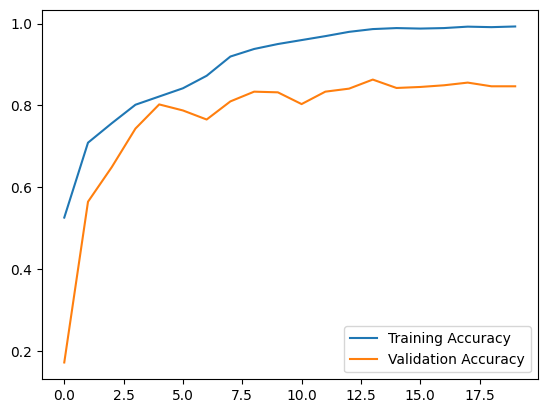

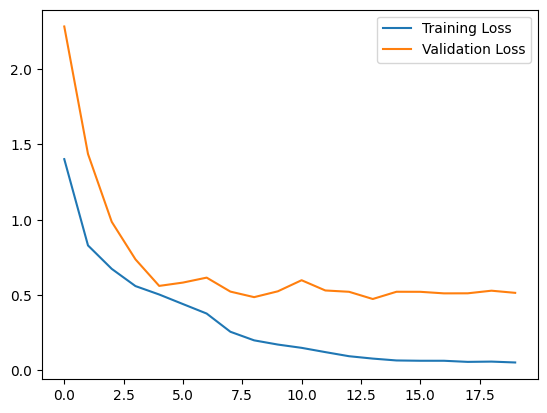

In [71]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [72]:

loss, accuracy = model.evaluate(x_test, y_test, batch_size=64)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8589 - loss: 0.5085
Test Loss: 0.5143980383872986
Test Accuracy: 0.8467212915420532


In [93]:

# Get predictions
predictions = model.predict(x_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
from sklearn.metrics import accuracy_score
manual_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Calculated Accuracy: {manual_accuracy}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Calculated Accuracy: 0.8467213114754099


In [74]:
class_map = list(class_map.keys()) 

In [77]:
# Save the trained model
model.save('Fake_Product.h5')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


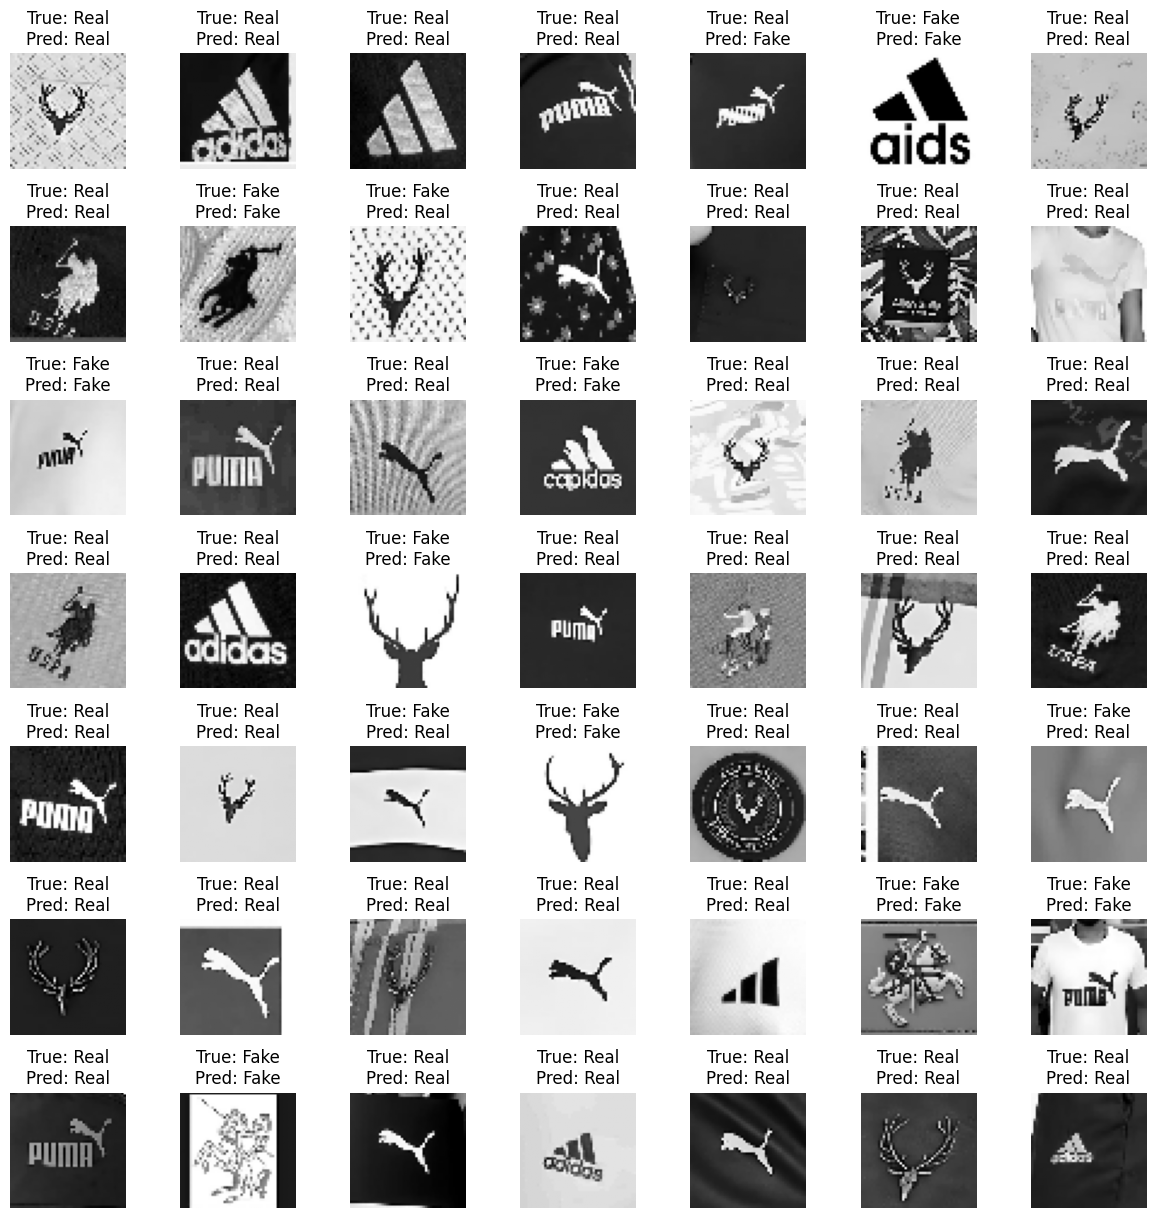

In [101]:
start_index = 1  # Change this to the desired starting index
end_index = 50    # Change this to the desired ending index
indices = np.arange(start_index, end_index)  # Generate the range of indices
num_samples = len(indices)

# Select the samples from the test set
sample_images = x_test[indices]
true_labels = [class_map[np.argmax(y_test[i])] for i in indices]
predictions = model.predict(sample_images.reshape(num_samples, 48, 48, 1))
predicted_labels = [class_map[np.argmax(pred)] for pred in predictions]

# Plot the images in a grid
grid_size = int(np.ceil(np.sqrt(num_samples)))  # Determine grid size (square)
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axes.flat):
    if i < num_samples:
        true_label = emoji_map.get(true_labels[i], true_labels[i])  # Replace with emoji
        predicted_label = emoji_map.get(predicted_labels[i], predicted_labels[i])  # Replace with emoji
        ax.imshow(sample_images[i].reshape(48, 48), cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused subplots

plt.show()

In [ ]:
# Count the number of correctly predicted labels
correct_predictions = sum([true_labels[i] == predicted_labels[i] for i in range(num_samples)])
print(f"Number of correctly predicted samples: {correct_predictions}")
print(f"Accuracy on the selected samples: {correct_predictions / num_samples:.2%}")